In [1]:
# 路透社数据集
import numpy as np
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(r'D:\reuters.npz',num_words=10000)
# 加载本地的数据集

Using TensorFlow backend.


In [2]:
# 参数 num_words=10000 将数据限定为前 10 000 个最常出现的单词。
# 我们有 8982 个训练样本和 2246 个测试样本。
print(len(train_data))
print(len(test_data))
# 与 IMDB 评论一样，每个样本都是一个整数列表（表示单词索引）。
print(train_data[10])

8982
2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [3]:
# 样本对应的标签是一个 0~45 范围内的整数，即话题索引编号。
print(train_labels[10])

3


In [4]:
# 准备数据
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
# one-hot 编码是分类数据广泛使用的一种格式，也叫分类编码（categorical encoding）。
# 在这个例子中，标签的one-hot编码就是将每个标签表示为全零向量，只有标签索引对应的元素为 1。其代码实现如下。
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)
# Keras 内置方法可以实现这个操作，在 MNIST 例子中已经见过这种方法。
# from keras.utils.np_utils import to_categorical
# one_hot_train_labels = to_categorical(train_labels)
# one_hot_test_labels = to_categorical(test_labels)

In [5]:
# 这个主题分类问题与前面的电影评论分类问题类似，两个例子都是试图对简短的文本片段进行分类。
# 但这个问题有一个新的约束条件：输出类别的数量从 2 个变为 46 个。输出空间的维度要大得多。
# 对于前面用过的 Dense 层的堆叠，每层只能访问上一层输出的信息。如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，
# 也就是说，每一层都可能成为信息瓶颈。
# 上一个例子使用了 16 维的中间层，但对这个例子来说 16 维空间可能太小了，无法学会区分 46 个不同的类别。
# 这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。
# 出于这个原因，下面将使用维度更大的层，包含 64 个单元。

In [6]:
# 模型定义
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
# 关于这个架构还应该注意另外两点。
# 1.网络的最后一层是大小为 46 的 Dense 层。这意味着，对于每个输入样本，网络都会输
# 出一个 46 维向量。这个向量的每个元素（即每个维度）代表不同的输出类别。
# 2.最后一层使用了 softmax 激活。网络将输出在 46个不同输出类别上的概率分布
# ——对于每一个输入样本，网络都会输出一个 46 维向量，其中 output[i] 是样本属于第 i 个类别的概率, 46 个概率的总和为 1。
# 对于这个例子，最好的损失函数是 categorical_crossentropy （分类交叉熵）。它用于衡量两个概率分布之间的距离，
# 这里两个概率分布分别是网络输出的概率分布和标签的真实分布。
# 通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签。

In [7]:
# 编译模型
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
# 留出验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]
print(x_val.shape)
print(partial_x_train.shape)
print(y_val.shape)
print(partial_y_train.shape)

(1000, 10000)
(7982, 10000)
(1000, 46)
(7982, 46)


In [10]:
# 训练模型
history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val, y_val))


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 5s 623us/step - loss: 2.6682 - accuracy: 0.5378 - val_loss: 1.7181 - val_accuracy: 0.6460
Epoch 2/20
7982/7982 [==============================] - 4s 449us/step - loss: 1.4019 - accuracy: 0.7110 - val_loss: 1.2967 - val_accuracy: 0.7250
Epoch 3/20
7982/7982 [==============================] - 3s 395us/step - loss: 1.0489 - accuracy: 0.7791 - val_loss: 1.1468 - val_accuracy: 0.7450
Epoch 4/20
7982/7982 [==============================] - 3s 382us/step - loss: 0.8301 - accuracy: 0.8244 - val_loss: 1.0386 - val_accuracy: 0.7690
Epoch 5/20
7982/7982 [==============================] - 4s 445us/step - loss: 0.6651 - accuracy: 0.8614 - val_loss: 0.9699 - val_accuracy: 0.8070
Epoch 6/20
7982/7982 [==============================] - 3s 376us/step - loss: 0.5379 - accuracy: 0.8921 - val_loss: 0.9279 - val_accuracy: 0.8040
Epoch 7/20
7982/7982 [==============================] - 3s 431us/step - los

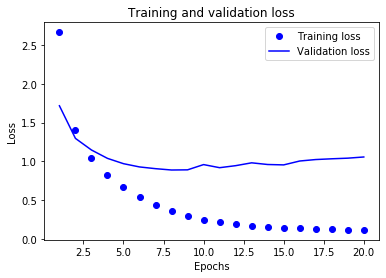

In [12]:
# 绘制训练损失和验证损失
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

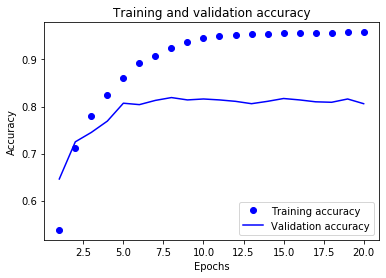

In [14]:
# 绘制训练精度和验证精度
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# 网络在训练 9 轮后开始过拟合。从头开始训练一个新网络，共 9 个轮次，然后在测试集上评估模型。
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=9,batch_size=512,validation_data=(x_val, y_val))
# 9个轮次
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 4s 527us/step - loss: 2.5987 - accuracy: 0.4790 - val_loss: 1.7708 - val_accuracy: 0.6210
Epoch 2/9
7982/7982 [==============================] - 4s 472us/step - loss: 1.4757 - accuracy: 0.6966 - val_loss: 1.3609 - val_accuracy: 0.7060
Epoch 3/9
7982/7982 [==============================] - 3s 354us/step - loss: 1.1048 - accuracy: 0.7657 - val_loss: 1.1825 - val_accuracy: 0.7430
Epoch 4/9
7982/7982 [==============================] - 3s 392us/step - loss: 0.8542 - accuracy: 0.8245 - val_loss: 1.0716 - val_accuracy: 0.7890
Epoch 5/9
7982/7982 [==============================] - 3s 369us/step - loss: 0.6741 - accuracy: 0.8626 - val_loss: 0.9670 - val_accuracy: 0.7990
Epoch 6/9
7982/7982 [==============================] - 3s 401us/step - loss: 0.5345 - accuracy: 0.8935 - val_loss: 0.9119 - val_accuracy: 0.8120
Epoch 7/9
7982/7982 [==============================] - 3s 405us/step - loss: 0.427

In [16]:
print(results)

[0.986677561502635, 0.7804986834526062]


In [17]:
# 这种方法可以得到约 78% 的精度。对于平衡的二分类问题，完全随机的分类器能够得到50% 的精度。
# 但在这个例子中，完全随机的精度约为 18%，所以上述结果相当不错，至少和随机的基准比起来还不错。
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print(float(np.sum(hits_array)) / len(test_labels))

0.1829919857524488


In [18]:
# 模型实例的 predict 方法返回了在 46 个主题上的概率分布。我们对所有测试数据生成主题预测。
# 在新数据上生成预测结果
predictions = model.predict(x_test)
# predictions 中的每个元素都是长度为 46 的向量。
print(predictions[0].shape)
# 这个向量的所有元素总和为 1。
print(np.sum(predictions[0]))
# 最大的元素就是预测类别，即概率最大的类别。
print(np.argmax(predictions[0]))

(46,)
0.99999994
3


In [19]:
# 处理标签和损失的另一种方法
# 另一种编码标签的方法，就是将其转换为整数张量，如下所示。
y_train = np.array(train_labels)
y_test = np.array(test_labels)
# 对于这种编码方法，唯一需要改变的是损失函数的选择。
# 对于以前代码使用的损失函数 categorical_crossentropy ，标签应该遵循分类编码。
# 对于整数标签，应该使用sparse_categorical_crossentropy 。
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# 这个新的损失函数在数学上与 categorical_crossentropy 完全相同，二者只是接口不同。

In [20]:
# 中间层维度足够大的重要性
# 前面提到，最终输出是 46 维的，因此中间层的隐藏单元个数不应该比 46 小太多。现在来
# 看一下，如果中间层的维度远远小于 46（比如 3 维），造成了信息瓶颈，那么会发生什么？
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(3, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=128,validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 5s 601us/step - loss: 2.8896 - accuracy: 0.3572 - val_loss: 2.3979 - val_accuracy: 0.3790
Epoch 2/20
7982/7982 [==============================] - 5s 572us/step - loss: 2.1866 - accuracy: 0.3862 - val_loss: 2.0815 - val_accuracy: 0.4160
Epoch 3/20
7982/7982 [==============================] - 5s 582us/step - loss: 1.8295 - accuracy: 0.4326 - val_loss: 1.7512 - val_accuracy: 0.4320
Epoch 4/20
7982/7982 [==============================] - 3s 377us/step - loss: 1.4529 - accuracy: 0.6000 - val_loss: 1.4752 - val_accuracy: 0.6330
Epoch 5/20
7982/7982 [==============================] - 5s 579us/step - loss: 1.2507 - accuracy: 0.6655 - val_loss: 1.4123 - val_accuracy: 0.6430
Epoch 6/20
7982/7982 [==============================] - 3s 422us/step - loss: 1.1490 - accuracy: 0.6705 - val_loss: 1.3773 - val_accuracy: 0.6440
Epoch 7/20
7982/7982 [==============================] - 3s 331us/step - loss

In [21]:
# 现在网络的验证精度最大约为 65%，比前面下降了 13%。
# 导致这一下降的主要原因在于，试图将大量信息（这些信息足够恢复 46 个类别的分割超平面）压缩到维度很小的中间空间。
# 网络能够将大部分必要信息塞入这个三维表示中，但并不是全部信息。

In [1]:
#  如果要对 N 个类别的数据点进行分类，网络的最后一层应该是大小为 N 的 Dense 层。
#  对于单标签、多分类问题，网络的最后一层应该使用 softmax 激活，这样可以输出在 N
# 个输出类别上的概率分布。
#  这种问题的损失函数几乎总是应该使用分类交叉熵。它将网络输出的概率分布与目标的
# 真实分布之间的距离最小化。
#  处理多分类问题的标签有两种方法。
#  通过分类编码（也叫 one-hot 编码）对标签进行编码，然后使用 categorical_
# crossentropy 作为损失函数。
#  将标签编码为整数，然后使用 sparse_categorical_crossentropy 损失函数。
#  如果你需要将数据划分到许多类别中，应该避免使用太小的中间层，以免在网络中造成
# 信息瓶颈。